In [97]:
import pandas as pd
import urllib.parse
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:

df_main = pd.read_csv("properties_data.csv", low_memory=False)
df = df_main[["id","location","Zip","Type","Subtype",
    "Price","Transaction Type","Bedrooms","Living area","Kitchen type",
    "Furnished","How many fireplaces?","Terrace","Terrace surface",
    "Garden","Garden surface","Surface of the plot","Number of frontages",
    "Swimming pool","Building condition","Primary energy consumption"]]
df = df.set_index("id")
df = df.drop(df[df["Type"]=="house group"].index)
df = df.drop(df[df["Type"]=="apartment group"].index)
df = df.rename(columns={
    'location' :'Locality',
    'Transaction Type' : 'Type of sale',
    'Type' :'Type of property',
    'Subtype' : 'Subtype of property',
    'Number of frontages': 'Number of facades',
    'Bedrooms':'Number of rooms',
    'Surface of the plot' :'Surface of the land',
    'Kitchen type' : 'Fully equipped kitchen',
    'How many fireplaces?' : 'Open fire'
})
 
#put the columns in a specific order'
df = df.reindex(columns=['Locality',"Zip", 'Type of property', 'Subtype of property',
                         'Type of sale', 'Price',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100
pd.set_option('display.float_format', '{:.2f}'.format)
print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

def clean_and_convert(column):
    column = column.apply(lambda x: re.sub('\D+', '', str(x)))
    column = column.replace('', np.nan)
    return column

df['Living area'] = clean_and_convert(df['Living area'])
df['Terrace surface'] = clean_and_convert(df['Terrace surface'])
df['Garden surface'] = clean_and_convert(df['Garden surface'])
df['Surface of the land'] = clean_and_convert(df['Surface of the land'])
df['Primary energy consumption'] = clean_and_convert(df['Primary energy consumption'])
df['Locality'] = df['Locality'].apply(urllib.parse.unquote)

# missing_value_df = df.isnull().mean() * 100
# missing_value_df

conditions = [
    (df['Garden']== "Yes"),
    (df["Garden"].isna()) & (df["Garden surface"].isna()),
    (df["Garden surface"].notna())
    ]
values = [1, 0, 1]
df['Garden'] = np.select(conditions, values)

df.loc[(df["Garden"] == 0 ) & (df["Garden surface"].isna()), 'Garden surface'] = 0
conditions = [
    (df['Terrace']== "Yes"),
    (df["Terrace"].isna()) & (df["Terrace surface"].isna()),
    (df["Terrace surface"].notna())
    ]
values = [1, 0, 1]
df['Terrace'] = np.select(conditions, values)

df.loc[(df["Terrace"] == 0 ) & (df["Terrace surface"].isna()), 'Terrace surface'] = 0
def nan_replacement(column):
    column = column.replace("Yes",1)
    column = column.replace("No",0)
    column = column.replace('', np.nan).fillna(0)
    return column

df['Furnished'] = nan_replacement(df['Furnished'])
df['Swimming pool'] = nan_replacement(df['Swimming pool'])
df['Open fire'] = nan_replacement(df['Open fire'])
df["Price"] = df["Price"].astype(int)
df = df.astype({"Price":"int",
                "Number of rooms":"float",
                "Living area":"float",
                "Terrace surface":"float",
                "Garden surface":"float",
                "Surface of the land":"float",
                "Number of facades":"float",
                "Primary energy consumption":"float"})
# Mapping dictionary for replacing values in the "kitchen" column
kitchen_mapping = {
    np.nan: -1,
    'Not installed': 0,
    'Installed': 1,
    'Semi equipped': 2,
    'Hyper equipped': 3,
    'USA uninstalled' :0,
    'USA installed': 1,
    'USA semi equipped': 2,
    'USA hyper equipped' :3
}
# Replace values in the "Kitchen type" column with corresponding numbers and create a new column called "Kitchen values"
df['Kitchen values'] = df['Fully equipped kitchen'].map(kitchen_mapping).fillna(df['Fully equipped kitchen']).astype(int)
building_cond_mapping = {
    np.nan: -1,
    'To restore': 0,
    'To be done up': 2,
    'Just renovated': 3,
    'To renovate': 1,
    'Good': 3,
    'As new' :4
}

df['Building Cond. values'] = df['Building condition'].map(building_cond_mapping).fillna(df['Building condition']).astype(int)
df = df.drop(df[df["Living area"].isna()].index)
#Missing values fillied with 1
df["Primary energy consumption"] = np.where((df["Primary energy consumption"] != int) & (df["Primary energy consumption"] == ""), 0, df["Primary energy consumption"])
df["Primary energy consumption"] = df["Primary energy consumption"].replace("",np.nan).fillna(-1).astype(int)

#New column with energy classes 
conditions = [
    (df['Primary energy consumption']==-1),
    (df['Primary energy consumption']>=1)&(df['Primary energy consumption']<100),
    (df['Primary energy consumption']>=100)&(df['Primary energy consumption']<200),
    (df['Primary energy consumption']>=200)&(df['Primary energy consumption']<300),
    (df['Primary energy consumption']>=300)&(df['Primary energy consumption']<400),
    (df['Primary energy consumption']>=400)&(df['Primary energy consumption']<500),
    (df['Primary energy consumption']>=500)&(df['Primary energy consumption']<600),
    (df['Primary energy consumption']>=600)
]

values = [-1,7, 6, 5, 4, 3, 2, 1]

df['Energy_classes'] = np.select(conditions, values)
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
# print(missing_value_df)
df.to_csv("clean_data.csv")

all_missing_value
Locality                       0.00
Zip                            0.00
Type of property               0.00
Subtype of property            0.00
Type of sale                   0.00
Price                          0.00
Building condition            15.89
Building Cond. values        100.00
Number of facades             23.73
Number of rooms                1.86
Living area                    3.40
Furnished                     46.42
Fully equipped kitchen        22.08
Kitchen values               100.00
Surface of the land           50.22
Primary energy consumption     0.00
Energy_classes               100.00
Terrace                       75.88
Terrace surface               53.57
Garden                        87.76
Garden surface                74.73
Open fire                     94.57
Swimming pool                 56.39
dtype: float64

houses_missing_value
Locality                       0.00
Zip                            0.00
Type of property               0.00
Subtype o

In [99]:
df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100

print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

all_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00
Type of sale                  0.00
Price                         0.00
Building condition           15.77
Building Cond. values         0.00
Number of facades            23.31
Number of rooms               1.84
Living area                   0.00
Furnished                     0.00
Fully equipped kitchen       21.81
Kitchen values                0.00
Surface of the land          49.83
Primary energy consumption    0.00
Energy_classes                0.00
Terrace                       0.00
Terrace surface              23.89
Garden                        0.00
Garden surface               12.25
Open fire                     0.00
Swimming pool                 0.00
dtype: float64

houses_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00


In [100]:
df['Price of square meter'] = df['Price'] / df['Living area']
df['Price of square meter'] = df['Price of square meter'].round(2)



In [101]:
def get_province(zip_code):
    if 1000 <= zip_code <= 1299:
        return 'Brussels Capital Region'
    elif 1300 <= zip_code <= 1499:
        return 'Walloon Brabant'
    elif 1500 <= zip_code <= 1999 or 3000 <= zip_code <= 3499:
        return 'Flemish Brabant'
    elif 2000 <= zip_code <= 2999:
        return 'Antwerp'
    elif 3500 <= zip_code <= 3999:
        return 'Limburg'
    elif 4000 <= zip_code <= 4999:
        return 'Liège'
    elif 5000 <= zip_code <= 5999:
        return 'Namur'
    elif 6000 <= zip_code <= 6599 or 7000 <= zip_code <= 7999:
        return 'Hainaut'
    elif 6600 <= zip_code <= 6999:
        return 'Luxembourg'
    elif 8000 <= zip_code <= 8999:
        return 'West Flanders'
    elif 9000 <= zip_code <= 9999:
        return 'East Flanders'
    else:
        return 'Unknown'
        
df['Province'] = df['Zip'].apply(get_province)


df = df.reindex(columns=['Locality',"Zip",'Province', 
                         'Type of property', 'Subtype of property',
                         'Type of sale', 'Price','Price of square meter',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df.to_csv("clean_data.csv")

In [102]:
# Define provinces in each region
flanders_provinces = ['Flemish Brabant','Antwerp','Limburg','West Flanders','East Flanders']
wallonia_provinces = ['Walloon Brabant','Liège','Namur','Hainaut','Luxembourg']
brussels_provinces = ['Brussels Capital Region']

df_flanders = df[df['Province'].isin(flanders_provinces)]
df_wallonia = df[df['Province'].isin(wallonia_provinces)]
df_brussels = df[df['Province'].isin(brussels_provinces)]
df_flanders

,Locality,Zip,Province,Type of property,Subtype of property,Type of sale,Price,Price of square meter,Building condition,Building Cond. values,...,Kitchen values,Surface of the land,Primary energy consumption,Energy_classes,Terrace,Terrace surface,Garden,Garden surface,Open fire,Swimming pool
id,,,,,,,,,,,,,,,,,,,,,
10578809,liedekerke,1770,Flemish Brabant,house,house,for sale,349000,1938.89,As new,4,...,3,256.00,241,5,1,25.00,1,150.00,0.00,0.00
10578941,sint-andries,8200,West Flanders,house,house,for sale,625000,3378.38,As new,4,...,3,539.00,292,5,0,0.00,1,400.00,0.00,0.00
10579000,nevele merendree,9850,East Flanders,house,house,for sale,460000,2787.88,As new,4,...,3,196.00,18,7,1,25.00,1,110.00,0.00,0.00
10576147,ronse,9600,East Flanders,house,house,for sale,265000,1577.38,Just renovated,3,...,1,182.00,144,6,1,20.00,1,82.00,0.00,0.00
10574972,antwerp,2060,Antwerp,house,house,for sale,239000,1593.33,To be done up,2,...,1,56.00,310,4,1,5.00,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577413,sint-truiden,3800,Limburg,apartment,apartment,for sale,284900,2907.14,NaN,-1,...,-1,NaN,-1,-1,1,18.00,1,NaN,0.00,0.00
10563952,nieuwpoort,8620,West Flanders,apartment,apartment,for sale,299000,6953.49,NaN,-1,...,3,NaN,318,4,1,NaN,0,0.00,0.00,0.00
9577415,sint-truiden,3800,Limburg,apartment,apartment,for sale,299900,2911.65,NaN,-1,...,-1,NaN,-1,-1,1,17.00,1,NaN,0.00,0.00


In [103]:
def calculate_metrics(region_df):
    return region_df.groupby('Province').agg(Avg_Price=('Price','mean'),
                                        Median_Price=('Price','median'),
                                        Price_Per_Sq_Meter=('Price of square meter','mean'))

In [104]:
belgium_metrics = calculate_metrics(df)
flanders_metrics = calculate_metrics(df_flanders)
wallonia_metrics = calculate_metrics(df_wallonia)
brussels_metrics = calculate_metrics(df_brussels)

print(flanders_metrics)

most_expensive_belgium = belgium_metrics['Avg_Price'].idxmax()
least_expensive_belgium = belgium_metrics['Avg_Price'].idxmin()

most_expensive_flanders = flanders_metrics['Avg_Price'].idxmax()
least_expensive_flanders = flanders_metrics['Avg_Price'].idxmin()

most_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmax()
least_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmin()

most_expensive_brussels = brussels_metrics['Avg_Price'].idxmax()
least_expensive_brussels = brussels_metrics['Avg_Price'].idxmin()


                         Avg_Price  Median_Price  Price_Per_Sq_Meter
Province                                                            
Antwerp                  497079.43     365000.00             3012.12
Brussels Capital Region  682773.87     440000.00             3884.83
East Flanders            413054.10     349000.00             2749.30
Flemish Brabant          545301.25     405000.00             2904.49
Hainaut                  251081.68     202500.00             1622.17
Limburg                  410916.74     319000.00             2282.55
Liège                    267996.27     225000.00             1801.81
Luxembourg               318142.73     280000.00             2028.43
Namur                    303391.63     260000.00             1889.47
Walloon Brabant          580771.98     435000.00             2909.52
West Flanders            632345.78     359000.00             4875.91


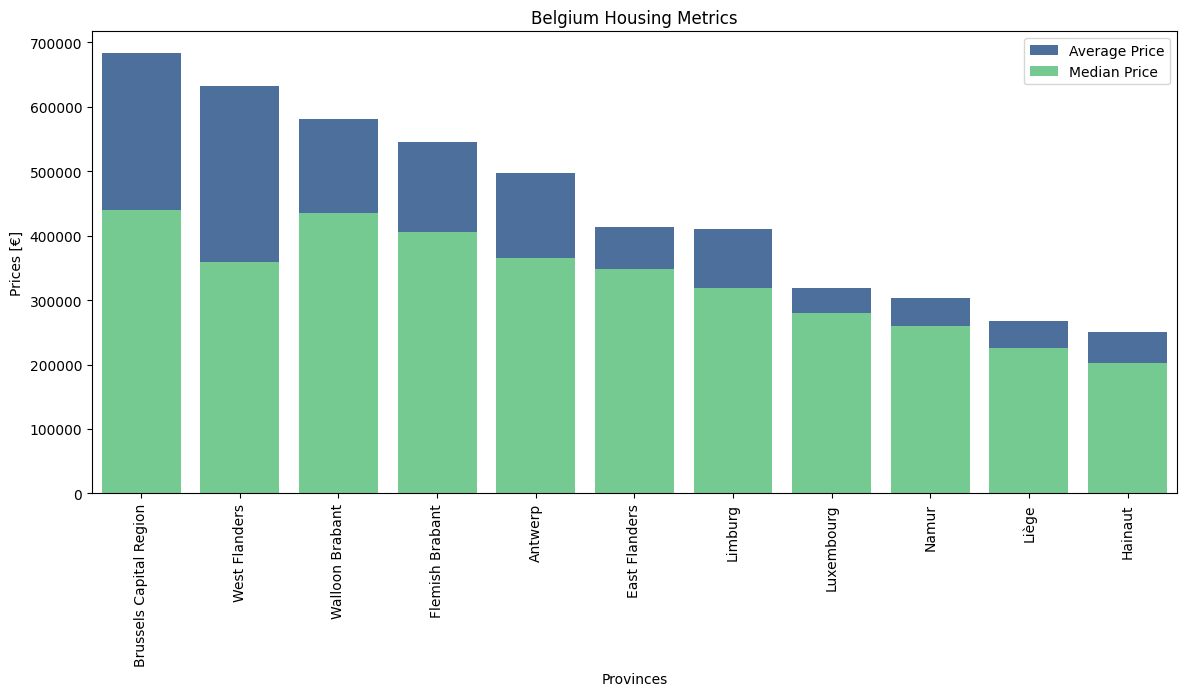

In [107]:

import seaborn as sns
belgium_metrics = belgium_metrics.sort_values('Avg_Price',ascending=False)
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
sns.barplot(data=belgium_metrics, x=belgium_metrics.index, y='Avg_Price', color='#3F6DA8', label='Average Price')
sns.barplot(data=belgium_metrics, x=belgium_metrics.index, y='Median_Price', color='#67D88E', label='Median Price')

# sns.barplot(data=belgium_metrics, x=belgium_metrics.index, y='Price_Per_Sq_Meter', color='red', label='Price per Sq. Meter')

plt.xlabel('Provinces')
plt.ylabel('Prices [€]')
plt.title('Belgium Housing Metrics')

plt.legend()
plt.show()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

print(f'Most expensive municipality in Belgium: {most_expensive_belgium}')
print(belgium_metrics.loc[most_expensive_belgium])
print(f'Least expensive municipality in Belgium: {least_expensive_belgium}')
print(belgium_metrics.loc[least_expensive_belgium])

print(f'Most expensive municipality in Flanders: {most_expensive_flanders}')
print(flanders_metrics.loc[most_expensive_flanders])
print(f'Least expensive municipality in Flanders: {least_expensive_flanders}')
print(flanders_metrics.loc[least_expensive_flanders])

print(f'Most expensive municipality in Wallonia: {most_expensive_wallonia}')
print(wallonia_metrics.loc[most_expensive_wallonia])
print(f'Least expensive municipality in Wallonia: {least_expensive_wallonia}')
print(wallonia_metrics.loc[least_expensive_wallonia])

print(f'Most expensive municipality in Brussels: {most_expensive_brussels}')
print(brussels_metrics.loc[most_expensive_brussels])
print(f'Least expensive municipality in Brussels: {least_expensive_brussels}')
print(brussels_metrics.loc[least_expensive_brussels])


In [ ]:
from ipyleaflet import Map, Heatmap

# Step 1: Calculate the average price for each zip code
avg_prices = df.groupby('Locality')['Price'].mean()

# Step 2: Initialize the zip_coordinates dictionary
zip_coordinates = {}

# Step 3: Read and populate the zip_coordinates dictionary with coordinates from the "BE.txt" file
with open('BE.txt', 'r', encoding='utf-8') as file:
    for line in file:
        data = line.split('\t')
        zip_code = data[1]
        latitude = float(data[4])
        longitude = float(data[5])
        zip_coordinates[zip_code] = (latitude, longitude)
print(zip_coordinates)
# Step 4: Create a list of coordinates and average prices for the heatmap
heatmap_data = []
for zip_code, avg_price in avg_prices.items():
    if zip_code in zip_coordinates:
        latitude, longitude = zip_coordinates[zip_code]
        heatmap_data.append([latitude, longitude, avg_price])

# Step 5: Create the map with the heatmap overlay
m = Map(center=(50.5039, 4.4699), zoom=8)
heatmap_layer = Heatmap(locations=heatmap_data, radius=10, min_opacity=0.5, max_opacity=0.8)
m.add_layer(heatmap_layer)
m
